# PAML for dynamic systems:
### Energy-based continuous-time models
Example system: Two mass oscillator

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Author: Fabian J. Roth

---

#### In this notebook, you will...

* Calibrate the energy-based continuous-time models: Hamiltonian, Lagrangian and port-Hamiltonian neural networks.
* Learn about canonical coordinates and their impact on the training of Hamiltonian coordinates.
* Train the models with data from a dissipative system
* Investigate the use of convex neural networks to bias a port-Hamiltonian neural network towards stability.

#### Contents
1. [Example System: The two mass oscillator](#theory_example_system)<br>
    1.1 [Data generation](#data_generation)<br>
2. [Theory: Hamiltonian and Lagrangian neural networks](#theory_hnn_lnn)<br>
3. [Task A](#task_1)<br>
    3.1 [Task A.1: Comparing HNNs and LNNs](#task_1_1)<br>
    3.2 [Task A.2: Different system parameters](#task_1_2)<br>
4. [Theory: Energy dissipation](#theory_phnn)<br>
5. [Task B: (s)PHNNs](#task_2)<br>

# 0. Installation
Run the following code cell to install the required packages. Then **restart your session** to make these packages available.

In [13]:
def is_colab():
    """Determine if the code is running in Google Colab."""
    try:
        import google.colab

        return True
    except ImportError:
        return False


if is_colab():
    print("Running in Google Colab, trying to install LecturePhysicsAwareML...")
    !git clone --depth 1 https://github.com/Drenderer/LecturePhysicsAwareML.git
    %cd LecturePhysicsAwareML/dynamic_modeling
    %pip install -e .
    print(
        "\n************************************************************************************\n\
        Make sure to restart the session after installation (Runtime > Restart Session).\n\
        ********************************************************************************"
    )
else:
    print(
        "Not running in Google Colab. \nPlease install the package manually if needed. If you are using pip, run:\n>>> pip install -e .\nin the dynamic_modeling directory."
    )

Not running in Google Colab. 
Please install the package manually if needed. If you are using pip, run:
>>> pip install -e .
in the dynamic_modeling directory.


In [2]:
from dynamic_modeling import (
    ODESolver
)
from dynamic_modeling.two_mass_oscillator import (
    TwoMassOscillator,
    plot_trajectory,
    plot_energy,
)
from dynamic_modeling.models import ACTIVATIONS
import klax

import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax

from jaxtyping import PRNGKeyArray, Array
from typing import Literal

import matplotlib.pyplot as plt

# Use jax in float 64 mode (not strictly necessary)
jax.config.update('jax_enable_x64', True)

# Define global keyword arguments for plotting
true_kwargs = dict(color="black", lw=2, marker='o', markevery=20)

# Set the seeds for the random number generator
key = jr.key(0)
model_key, loader_key = jr.split(key)

## 1. Example System: The two mass oscillator <a id='theory_example_system'></a>
In this task we consider a simple linear two mass oscillator system:

<img src="images\Two_mass_oscillator.png" height="200"/>

Describing position of the masses $m_1$ and $m_2$ with generalized coordinates $q_1, q_2$ and their velocities $\dot q_1, \dot q_2$, the total kinetic energy $T$ and potential energy $U$ are given by
$$
\begin{align}
    T = \frac{1}{2}m_1 \dot q_1^2 + \frac{1}{2}m_2 \dot q_2^2, && U = \frac{1}{2}k_1q_1^2 + \frac{1}{2}k_2(q_2 - q_1)^2.
\end{align}
$$

with spring constants $k_1$ and $k_2$.

In the last exercise we used the Euler-Lagrange equation to obtain the equations of motion. So naturally, this time we'll use the Hamiltonian framework. This requires us to use the generalized momenta $p_i = m_i \dot q_i$ instead of the velocities $v_i=\dot q_i$. 
By substituting $q_i = \frac{p_i}{m_i}$ we can formulate the Hamiltonian $\mathcal{H}$ as the total energy:
$$
\begin{align}
    \mathcal{H}(q_1, q_2, p_1, p_2) = T + U = \frac{1}{2m_1}p_1^2 + \frac{1}{2m_2}p_2^2 + \frac{1}{2}k_1q_1^2 + \frac{1}{2}k_2(q_2 - q_1)^2 + C
\end{align}
$$
where $C$ is an arbitrary constant corresponding to the chosen zero-level of the potential energy.

Now we use Hamiltons equations of motion
$$
\begin{align}
    \frac{\partial q_i}{\partial t} &= \phantom{-}\frac{\partial \mathcal{H}}{\partial p_i}, \qquad\qquad i=1,2\\
    \frac{\partial p_i}{\partial t} &= -\frac{\partial \mathcal{H}}{\partial q_i}, \qquad\qquad i=1,2
\end{align}
$$
and plug in our $\mathcal{H}$. After rewriting it in terms of velocities $v_1 = \frac{p_1}{m_1}, v_y = \frac{p_2}{m_2}$ we get:
$$
\begin{align}
\dot q_1 &= v_x\\
\dot q_2 &= v_y\\
\dot v_1 &= -\frac{k_1 + k_2}{m_1}q_1 + \frac{k_2}{m_1}q_1\\
\dot v_2 &= \frac{k_2}{m_2}q_1 - \frac{k_2}{m_2}q_2
\end{align}
$$

Let's generate some trajectories, using varying initial positions.

## 1.1 Data generation <a id='data_generation'></a>
The following code cells generate and visualize data from the spring pendulum system.

Feel free to change the parameters marked by ``# <<<`` *later* during the tasks.

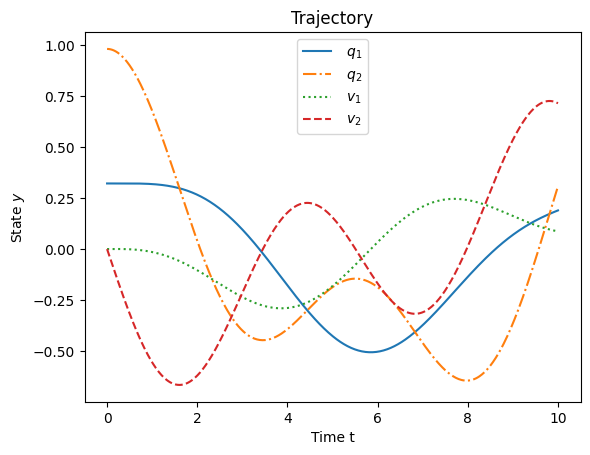

In [14]:
two_mass_oscillator = TwoMassOscillator(m1=3.0, m2=0.5, k1=1.0, k2=0.5, c1=0.0, c2=0.0) # Change this in later tasks
true_system = ODESolver(two_mass_oscillator)

num_traj = 20           # <<< Number of trajectories
t_max = 10              # <<< Length of trajectories [s]
num_t_samples = 500     # <<< Number of samples per trajectory

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, t_max, num_t_samples)

# Generate random initial conditions for training
q0s = jr.uniform(r_key, (num_traj, 2), minval=-1.0, maxval=1.0)
q_t0s = jnp.zeros_like(q0s)
y0s = jnp.concat([q0s, q_t0s], axis=-1)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

# Make derivative data
ys_flat = jnp.reshape(ys, (-1, ys.shape[-1]))
ys_t_flat = jax.vmap(two_mass_oscillator, (None, 0))(None, ys_flat)

# Plot an example trajectory
trajectory_index = 1    # <<< Plot trajectory with index (0,...,num_traj-1)
plot_trajectory(ts, ys[trajectory_index], states="all") # type:ignore
plt.show()

## 2. Theory: Hamiltonian and Lagrangian neural networks <a id='theory_hnn_lnn'></a>
In this task we will train and compare Hamiltonian and Lagrangian neural netwoks.
### 2.1 Hamiltonian neural networks
Similar to a nerual ODE Hamiltonian neural networks parameterize a first order ODE $\dot{\mathbf{y}} = f_{NN}(\mathbf{y})$. However, $f_{NN}$ is not parameterized with a neural network directly. Instead, we use Hamiltons equations of motion:
$$
\begin{equation}
    \dot{\mathbf{y}} = f_{NN}(\mathbf{y}) = \underbrace{\begin{bmatrix}\mathbf{0}&\mathbf{I}\\-\mathbf{I}&\mathbf{0}\end{bmatrix}}_{\mathbf{\Omega}}\frac{\partial\mathcal{H}(\mathbf{y})}{\partial\mathbf{y}}
\end{equation}
$$
with the *Hamiltonian* function $\mathcal{H}(\mathbf{y}):\;\mathbb{R}^n\mapsto\mathbb{R}$, which represents the total energy of the system $\mathcal{H} = T+ U$.
The Hamiltonian modeling framework requires the use of so called *canonical coordinates* this means that the state vector $\mathbf{y}$ should consist of the generalized positions $\mathbf{q}$ and the corresponding generalized momenta $\mathbf{p}$:
$$
\mathbf{y} = \begin{bmatrix}\mathbf{q}\\\mathbf{p}\end{bmatrix}.
$$
We can thus rewrite the equation of motion as:
$$
\begin{align}
    \dot{\mathbf{q}} = \frac{\partial \mathcal{H}}{\partial \mathbf{p}} \qquad
    \dot{\mathbf{p}} = -\frac{\partial \mathcal{H}}{\partial \mathbf{q}}
\end{align}
$$
By parameterizing the Hamiltonian using a neural network $\mathcal{H}_{NN} = NN(\mathbf{y}; \mathbf{\phi})$ with parameters $\mathbf{\phi}$ we obtain a *Hamiltonian neural network*.

Hamiltonian neural networks are constrained to conserve the Hamiltonian, which follows directly from using Hamiltons equations of motion:
$$
\begin{align}
    \dot{\mathcal{H}}(\mathbf{y}(t)) = \frac{\partial \mathcal{H}}{\partial \mathbf{y}} \cdot \dot{\mathbf{y}} = \frac{\partial \mathcal{H}}{\partial \mathbf{y}}^\intercal\mathbf{\Omega}\frac{\partial \mathcal{H}}{\partial \mathbf{y}} = 0
\end{align}
$$
The last equatlity is a consequence of the fact that the canonical symplectic matrix $\mathbf{\Omega}$ is skew-symmetric ($\mathbf{\Omega}=-\mathbf{\Omega}^\intercal$), which implies $\mathbf{x}^\intercal\mathbf{\Omega}\mathbf{x}=0,\;\forall\mathbf{x}\in\mathbb{R}^n$

### 2.2 Lagrangian neural networks
Instead of the Hamiltonian, we can also use the Lagrangian modeling framework to formulate a constraint continuous-time dynamical ML model. Here we use the Euler-Lagrange equation as a starting point:
$$
\begin{equation}
    \frac{\partial \mathcal{L}}{\partial \mathbf{q}} - \frac{\mathrm{d}}{\mathrm{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\mathbf{q}}} = 0.
\end{equation}
$$
Here $\mathcal{L}(\mathbf{q}, \dot{\mathbf{q}}):\;\mathbb{R}^n\mapsto\mathbb{R}$ is the *Lagrangian*. It is given by the difference of the kinetic and potential energies $\mathcal{L} = T - U$. By propagating the time derivative and rearranging we get:
$$
\begin{equation}
    \ddot{q} = (\nabla_{\dot{q}}\nabla_{\dot{q}}^T\mathcal{L})^{-1}[\nabla_q\mathcal{L}-(\nabla_q\nabla_{\dot{q}}^T\mathcal{L})\dot{q}].
\end{equation}
$$
Here we use the Nabla notation: $\nabla_x =\frac{\partial}{\partial x}$. Similar to before, we parameterize the Lagrangian using a neural network $\mathcal{L}_{NN} = NN(\mathbf{y}; \mathbf{\phi})$ with parameters $\mathbf{\phi}$ and obtain a *Lagrangian neural network*.
It can be shown that the Euler-Lagrange equation also implies conservation of the total energy $E=T+U$ if $\mathcal{L} = T - U$. In fact, the Lagrangian and Hamiltonian frameworks are mathematically equivalent (The Hamiltonian can be calculated from the Lagrangian and vice versa).


The following code cell implements the derivative functions of Hamiltonian and Lagrangian neural networks:

In [4]:
class HamiltonianNN(eqx.Module):
    hamiltonian: klax.nn.MLP

    def __init__(self, 
                 *,
                 state_size: int = 4,
                 hidden_layer_sizes: list[int] = [16, 16],
                 activation: Literal["softplus", "relu", "sigmoid"] = "softplus",
                 key: PRNGKeyArray):
        self.hamiltonian = klax.nn.MLP(
            in_size=state_size,
            out_size="scalar",
            width_sizes=hidden_layer_sizes,
            activation=ACTIVATIONS[activation],
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        grad_H = jax.grad(self.hamiltonian)(y)
        dH_dq, dH_dp = jnp.split(grad_H, 2, axis=-1)
        dq_dt = dH_dp
        dp_dt = -dH_dq
        return jnp.concatenate([dq_dt, dp_dt], axis=-1)
    
class LagrangianNN(eqx.Module):
    lagrangian: klax.nn.MLP

    def __init__(self, 
                 *,
                 state_size: int = 4,
                 hidden_layer_sizes: list[int] = [16, 16],
                 activation: Literal["softplus", "relu", "sigmoid"] = "softplus",
                 key: PRNGKeyArray):
        self.lagrangian = klax.nn.MLP(
            in_size=state_size,
            out_size="scalar",
            width_sizes=hidden_layer_sizes,
            weight_init=jax.nn.initializers.normal(stddev=0.1), # We require custom weight initialization because LNNs are very picky
            activation=ACTIVATIONS[activation],
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        q, q_t = jnp.split(y, 2, axis=-1)

        # Redefine the Lagrangian in terms of the generalized coordinates and velocities.
        # This is necessary to differentiate with respect to q and q_t individually.
        def _lagrangian(q, q_t):
            y = jnp.concat([q, q_t], axis=-1)
            return self.lagrangian(y)

        q_tt = jax.numpy.linalg.pinv(jax.hessian(_lagrangian, 1)(q, q_t)) @ (
                jax.grad(_lagrangian, 0)(q, q_t)
                - jax.jacfwd(jax.grad(_lagrangian, 1), 0)(q, q_t) @ q_t
            )
        return jnp.concat([q_t, q_tt])
    

# Here we define the loss function. 
# We will be using only derivative fitting for this task, which 
# allows us to train the models faster than with trajectory fitting.
def derivative_loss(model: ODESolver, data, batch_axis):
    """Evaluate the models derivative function and compare it to the true derivative."""
    ys, ys_t = data
    ys_t_pred = jax.vmap(model.func, in_axes=0)(None, ys)
    return jnp.mean(jnp.square(ys_t_pred - ys_t))
    

# 3. Task A <a id='task_1'></a>
## 3.1 Task A.1: Comparing HNNs and LNNs <a id='task_1_1'></a>
With a partner (one person does (a) the other (b)) run the code in the cells below:

a) Hamiltonian neural network (HNN)

b) Lagrangian neural network (HNN)

and then plot the prediction(s) (3rd code cell below). Consider the following questions:

1) What differences between the models do you observe during training?
2) Pay particular attention to *extrapolation* in time by evaluating the models on time series that extend beyond the duration of the training data (e.g., in the evaluation cell set ``t_max_eval`` to 50 or 100). What do you observe? Compare to the results from the neural ODE from the previous task.
3) Do the models preserve the energy exactly? Explain why or why not.
4) _(optional, difficult)_ Do the models learn the "true" Hamiltonian/Lagrangian? How can the differences be explained?

<details>
<summary>Click here for a hint for 4)</summary>
Think about potential transformations of the Hamiltonian/Lagrangian that leave the evolution equations (Hamiltons equations or the Euler-Lagrange equation) unchanged.
</details>

Step: 0, Loss: 3.192e-01
Step: 100, Loss: 2.027e-02
Step: 200, Loss: 1.424e-02
Step: 300, Loss: 1.400e-02
Step: 400, Loss: 1.352e-02
Step: 500, Loss: 1.341e-02
Step: 600, Loss: 1.339e-02
Step: 700, Loss: 1.304e-02
Step: 800, Loss: 1.305e-02
Step: 900, Loss: 1.311e-02
Step: 1000, Loss: 1.288e-02
Step: 1100, Loss: 1.272e-02
Step: 1200, Loss: 1.281e-02
Step: 1300, Loss: 1.272e-02
Step: 1400, Loss: 1.255e-02
Step: 1500, Loss: 1.248e-02
Step: 1600, Loss: 1.243e-02
Step: 1700, Loss: 1.263e-02
Step: 1800, Loss: 1.263e-02
Step: 1900, Loss: 1.232e-02
Step: 2000, Loss: 1.243e-02
Step: 2100, Loss: 1.241e-02
Step: 2200, Loss: 1.230e-02
Step: 2300, Loss: 1.221e-02
Step: 2400, Loss: 1.215e-02
Step: 2500, Loss: 1.218e-02
Step: 2600, Loss: 1.217e-02
Step: 2700, Loss: 1.214e-02
Step: 2800, Loss: 1.207e-02
Step: 2900, Loss: 1.228e-02
Step: 3000, Loss: 1.231e-02
Step: 3100, Loss: 1.306e-02
Step: 3200, Loss: 1.214e-02
Step: 3300, Loss: 1.204e-02
Step: 3400, Loss: 1.211e-02
Step: 3500, Loss: 1.194e-02
Step

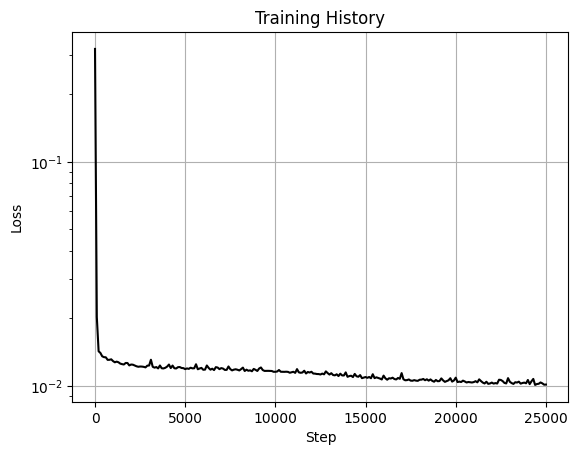

In [15]:
# Hamiltonian neural network (HNN)
hnn_derivative = HamiltonianNN(
    hidden_layer_sizes=[32, 32],    # <<< NN size
    activation="softplus",          # <<< Activation function "softplus", "relu" or "sigmoid"
    key=model_key
)
hnn = ODESolver(hnn_derivative)

hnn, hist = klax.fit(
    hnn,
    (ys_flat, ys_t_flat),
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()

Step: 0, Loss: 7.730e+02
Step: 100, Loss: 7.899e+00
Step: 200, Loss: 4.127e-01
Step: 300, Loss: 3.128e-01
Step: 400, Loss: 2.935e-01
Step: 500, Loss: 2.766e-01
Step: 600, Loss: 2.588e-01
Step: 700, Loss: 2.418e-01
Step: 800, Loss: 2.261e-01
Step: 900, Loss: 2.085e-01
Step: 1000, Loss: 1.930e-01
Step: 1100, Loss: 1.783e-01
Step: 1200, Loss: 1.647e-01
Step: 1300, Loss: 1.524e-01
Step: 1400, Loss: 1.402e-01
Step: 1500, Loss: 1.288e-01
Step: 1600, Loss: 1.189e-01
Step: 1700, Loss: 1.092e-01
Step: 1800, Loss: 1.004e-01
Step: 1900, Loss: 9.264e-02
Step: 2000, Loss: 8.545e-02
Step: 2100, Loss: 7.896e-02
Step: 2200, Loss: 7.233e-02
Step: 2300, Loss: 6.665e-02
Step: 2400, Loss: 6.132e-02
Step: 2500, Loss: 5.656e-02
Step: 2600, Loss: 5.224e-02
Step: 2700, Loss: 4.817e-02
Step: 2800, Loss: 4.446e-02
Step: 2900, Loss: 4.107e-02
Step: 3000, Loss: 3.803e-02
Step: 3100, Loss: 3.517e-02
Step: 3200, Loss: 3.259e-02
Step: 3300, Loss: 3.027e-02
Step: 3400, Loss: 2.804e-02
Step: 3500, Loss: 2.611e-02
Step

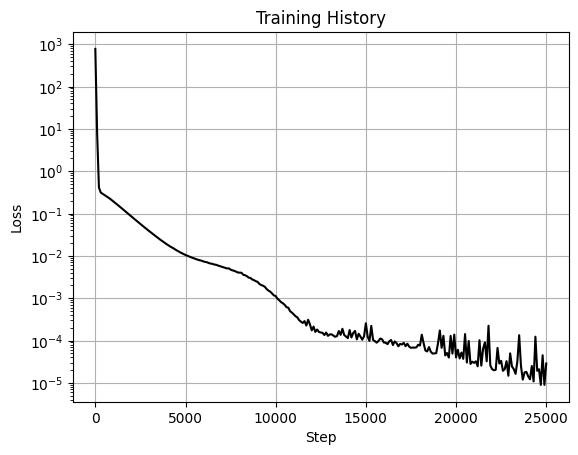

In [16]:
# Lagrangian neural network (LNN)
lnn_derivative = LagrangianNN(
    hidden_layer_sizes=[32, 32],    # <<< NN size
    activation="softplus",          # <<< Activation function "softplus", "relu" or "sigmoid"
    key=model_key
)
lnn = ODESolver(lnn_derivative)

lnn, hist = klax.fit(
    lnn,
    (ys_flat, ys_t_flat),
    steps=25_000,
    loss_fn=derivative_loss,
    optimizer=optax.adam(1e-4),
    key=loader_key,
)

hist.plot()

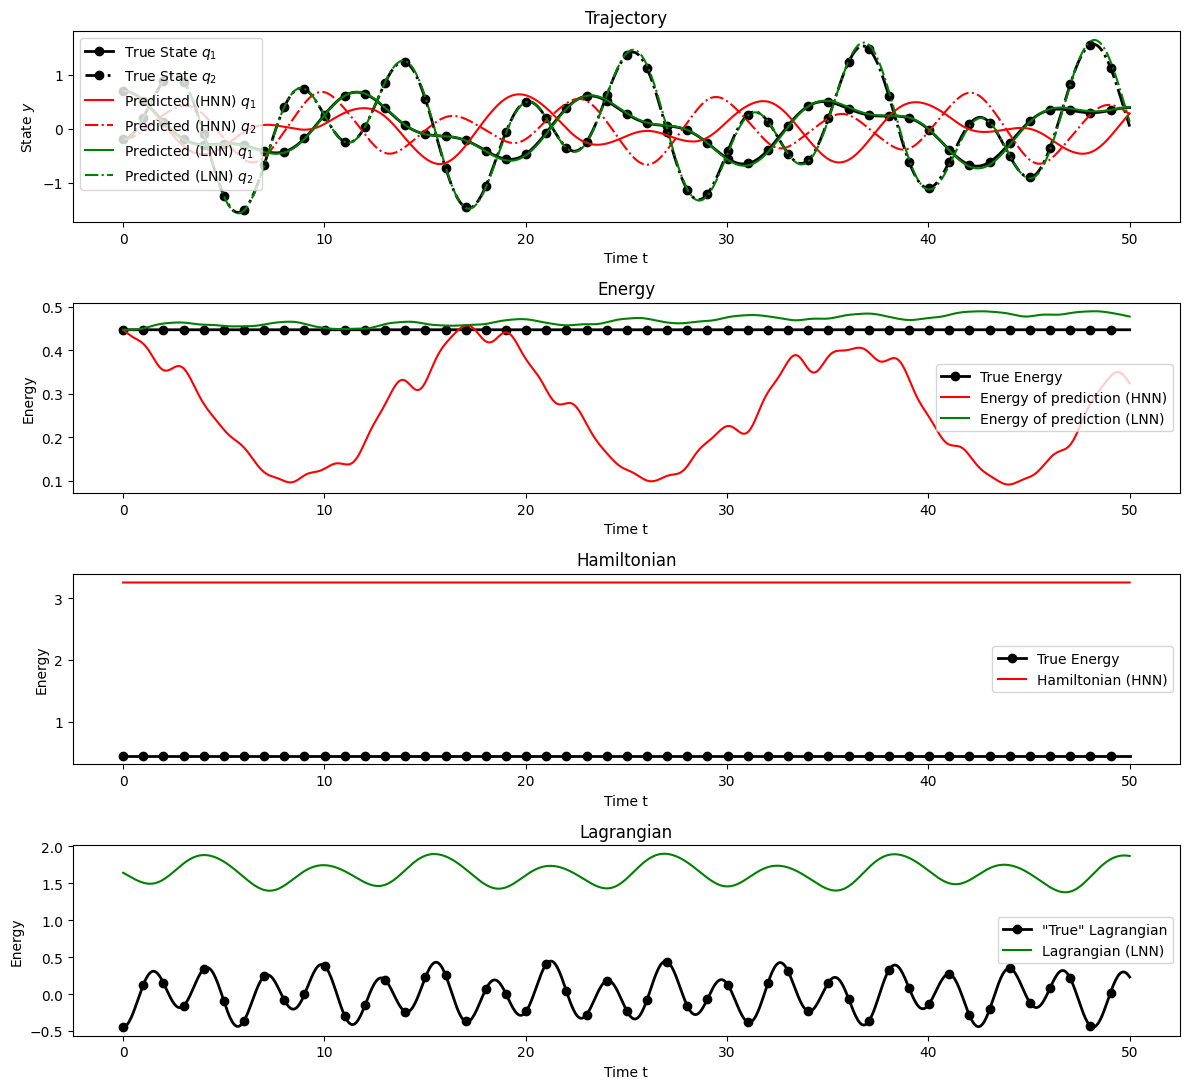

In [17]:
# Plot the model prediction(s)
y0_eval = jnp.array([0.7, -0.2, 0.0, 0.0])  # <<< Initial condition for evaluation
t_max_eval = 50                             # <<< Length of evaluation trajectory
states = "positions"                        # <<< Plot only: "positions", "velocities" or "all"
ts_eval = jnp.linspace(0, t_max_eval, 1000)


fig, axes = plt.subplots(4, 1, figsize=(12, 11))
ys_true = true_system(ts_eval, y0_eval)
plot_trajectory(ts_eval, ys_true, ax=axes[0], label="True State", states=states, **true_kwargs)
E_true = jax.vmap(two_mass_oscillator.get_energy)(ys_true)
plot_energy(ts_eval, E_true, ax=axes[1], label="True Energy", **true_kwargs)   # type: ignore
plot_energy(ts_eval, E_true, ax=axes[2], label="True Energy", **true_kwargs)   # type: ignore
lagrangian_true = jax.vmap(two_mass_oscillator.get_lagrangian)(ys_true)
plot_energy(ts_eval, lagrangian_true, ax=axes[3], label="\"True\" Lagrangian", **true_kwargs)   # type: ignore
try:
    ys_pred_hnn = hnn(ts_eval, y0_eval)
    plot_trajectory(ts_eval, ys_pred_hnn, ax=axes[0], states=states, color="red", label="Predicted (HNN)")
    E_pred_hnn = jax.vmap(two_mass_oscillator.get_energy)(ys_pred_hnn)
    plot_energy(ts_eval, E_pred_hnn, ax=axes[1], color="red", label="Energy of prediction (HNN)")   # type: ignore
    hamiltonian_hnn = jax.vmap(hnn.func.hamiltonian)(ys_pred_hnn)
    plot_energy(ts_eval, hamiltonian_hnn, ax=axes[2], color="red", label="Hamiltonian (HNN)")   # type: ignore
except NameError:
    print("You have not trained the Hamiltonian NN (hnn). Skipping this model.")
try:
    ys_pred_lnn = lnn(ts_eval, y0_eval)
    plot_trajectory(ts_eval, ys_pred_lnn, ax=axes[0], states=states, color="green", label="Predicted (LNN)")
    E_pred_lnn = jax.vmap(two_mass_oscillator.get_energy)(ys_pred_lnn)
    plot_energy(ts_eval, E_pred_lnn, ax=axes[1], color="green", label="Energy of prediction (LNN)")   # type: ignore
    lagrangian_lnn = 20*jax.vmap(lnn.func.lagrangian)(ys_pred_lnn)
    plot_energy(ts_eval, lagrangian_lnn, ax=axes[3], color="green", label="Lagrangian (LNN)")   # type: ignore
except NameError:
    print("You have not trained the Lagrangian NN (lnn). Skipping this model.")
axes[2].set(title="Hamiltonian")
axes[3].set(title="Lagrangian")
plt.tight_layout()
plt.show()

## 3.2 Task A.2: Different system parameters <a id='task_1_2'></a>
In our data generation we used $m_1=m_2=1$. Go to the [data generation code cell](#data_generation) and 

a) choose **different** masses, e.g., ``... TwoMassOscillator(m1=3.0, m2=0.5, k1=1.0, k2=0.5)``

b) (optional) choose positive dissipation coefficients ``... TwoMassOscillator(m1=3.0, m2=0.5, k1=1.0, k2=0.5, c1=0.4, c2=0.1)``

Then rerun the model training again.
Can the models still fit the data? If not, why not?

<details>
<summary>Click here for a hint for a)</summary>
For the two mass oscillator the canonical momenta are given by p=m*v.
</details>


$\quad$

## 4. Theory: Energy dissipation <a id='theory_phnn'></a>

You might have noticed in the previous task that the Hamiltonian and Lagrangian NNs cannot learn the dissipative system. This is not suprising, as they are constrained to conserve a "energy-like" quantity. In practice most interesting systems are dissipative. In this final task we explore the use of port-Hamiltonian neural networks to learn dissipative systems.

### 4.1 Port-Hamiltonian neural network (PHNN)
In the port-Hamiltonian modeling framework we extend the Hamiltonian evolution equation by introducing an additional matrix: 
$$
\begin{equation}
    \dot{\mathbf{y}} = \big(\mathbf{J}(\mathbf{y}) - \mathbf{R}(\mathbf{y})\big)\frac{\partial\mathcal{H}(\mathbf{y})}{\partial\mathbf{y}}
\end{equation}
$$
Here $\mathbf{R}$ is the *positive semi-definite* dissipation matrix and $\mathbf{J}$ is a *skew-symmetric* structure matrix.
Both matrices can potentially depend on the systems state $\mathbf{J}: \mathbb{R}^n\mapsto\mathbb{R}^{n\times n}$ and $\mathbf{R}: \mathbb{R}^n\mapsto\mathbb{R}^{n\times n}$.
(We could also add and input matrix $\mathbf{G}(\mathbf{y})$ to allow for external inputs $\mathbf{u}$, e.g., forces that act on the masses. However, since we do not consider a forced system in this tutorial, we will ignore $\mathbf{G}$ and $\mathbf{u}$ here)

Whereas the HNN exactly conserved the Hamiltonian $\mathcal{H}$, the pHNN can dissipate the Hamiltonian. By using the properties of skew-symmetric and positive definite matrices we can derive the dissipation inequality:
$$
\begin{align}
    \dot{\mathcal{H}}(\mathbf{y}(t)) = \frac{\partial \mathcal{H}}{\partial \mathbf{y}} \dot{\mathbf{y}} = \underbrace{\frac{\partial \mathcal{H}}{\partial \mathbf{y}}^\intercal\mathbf{J}\frac{\partial \mathcal{H}}{\partial \mathbf{y}}}_{=0} - \underbrace{\frac{\partial \mathcal{H}}{\partial \mathbf{y}}^\intercal\mathbf{R}\frac{\partial \mathcal{H}}{\partial \mathbf{y}}}_{\geq0} \leq 0
\end{align}
$$

We parameterize $\mathcal{H},\,\mathbf{J}$ and $\mathbf{R}$ with neural networks and learn them from data.

### 4.2 stable Port-Hamiltonian neural network (sPHNN)
The port-Hamiltonian framework above guarantees that the Hamiltonian cannot increase along predicted trajectories. However, so far the Hamiltonian is an unconstrained neural network and can get arbitrarily small/negative. Thus we can still have trajectories that blow up or are unstable. 

We can provide and additional *inductive bias* by constrianing the Hamiltonian. In particular, we can use a **convex neural network** to parameterize $\mathcal{H}$. Since a convex function can only have one (global) minimum we can guarantee<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) properties like stability and boundedness this way. This also improves the training.

<a name="cite_note-1"></a><sup>1</sup>We would need to ensure that the convex function *actually* has a minimum, but in many cases convex neural networks already provide a strong enough bias.

The following code cell implements (s)PHNNs:

In [8]:
class PortHamiltonianNN(eqx.Module):
    hamiltonian: klax.nn.MLP | klax.nn.FICNN
    J: klax.nn.ConstantSkewSymmetricMatrix
    R: klax.nn.ConstantSPDMatrix

    def __init__(self, convex_hamiltonian=False, *, key: PRNGKeyArray):
        NN_type = klax.nn.FICNN if convex_hamiltonian else klax.nn.MLP
        self.hamiltonian = NN_type(
            in_size=4,
            out_size="scalar",
            width_sizes=[16, 16],
            key=key,
        )
        self.J = klax.nn.ConstantSkewSymmetricMatrix(
            shape=(4,4),
            key=key,
        )
        self.R = klax.nn.ConstantSPDMatrix(
            shape=(4,4),
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        grad_H = jax.grad(self.hamiltonian)(y)
        return (self.J(y) - self.R(y)) @ grad_H

## 5. Task B: (s)PHNNs <a id='task_2'></a>

We now consider the damped two mass oscillator system:

<img src="images\Two_mass_oscillator_damped.png" height="200"/>

Go to the  [data generation code cell](#twomassdatageneration) and choose positive dissipation coefficients and non-equal masses. For example:  ``... TwoMassOscillator(m1=3.0, m2=0.5, k1=1.0, k2=0.5, c1=0.4, c2=0.1)``

Then use the code cells below to train both a PHNN and a sPHNN.

Consider the following questions:

1) Can the models represent the dissipative dynamics? What do you expect and what do you observe in practice?
2) Are performance differences between the PHNN and the sPHNN? How might they be explained?
3) _(optional, difficult)_: Can (s)PHNN learn the system with different masses? Why might it succeed here, where HNNs failed?


Step: 0, Loss: 2.398e-01
Step: 100, Loss: 5.958e-02
Step: 200, Loss: 5.003e-02
Step: 300, Loss: 4.284e-02
Step: 400, Loss: 3.289e-02
Step: 500, Loss: 2.344e-02
Step: 600, Loss: 1.877e-02
Step: 700, Loss: 1.710e-02
Step: 800, Loss: 1.594e-02
Step: 900, Loss: 1.502e-02
Step: 1000, Loss: 1.400e-02
Step: 1100, Loss: 1.316e-02
Step: 1200, Loss: 1.231e-02
Step: 1300, Loss: 1.149e-02
Step: 1400, Loss: 1.075e-02
Step: 1500, Loss: 1.009e-02
Step: 1600, Loss: 9.526e-03
Step: 1700, Loss: 8.983e-03
Step: 1800, Loss: 8.508e-03
Step: 1900, Loss: 7.968e-03
Step: 2000, Loss: 7.518e-03
Step: 2100, Loss: 6.995e-03
Step: 2200, Loss: 6.512e-03
Step: 2300, Loss: 6.061e-03
Step: 2400, Loss: 5.581e-03
Step: 2500, Loss: 5.169e-03
Step: 2600, Loss: 4.713e-03
Step: 2700, Loss: 4.268e-03
Step: 2800, Loss: 3.861e-03
Step: 2900, Loss: 3.490e-03
Step: 3000, Loss: 3.146e-03
Step: 3100, Loss: 2.902e-03
Step: 3200, Loss: 2.637e-03
Step: 3300, Loss: 2.373e-03
Step: 3400, Loss: 2.212e-03
Step: 3500, Loss: 2.069e-03
Step

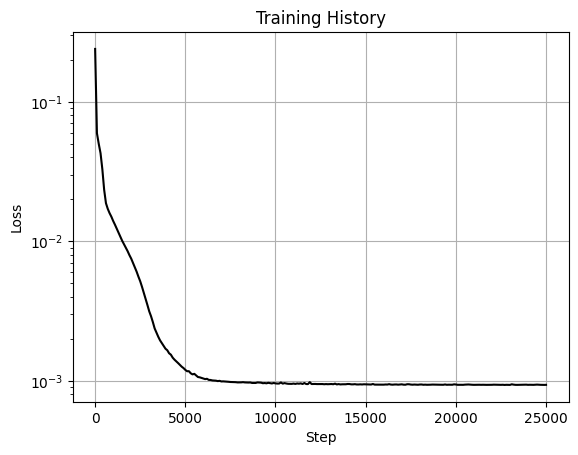

In [9]:
# Port-Hamiltonian neural network (PHNN)
phnn_derivative = PortHamiltonianNN(
    convex_hamiltonian = False,
    key=model_key
)
phnn = ODESolver(phnn_derivative)

phnn, hist = klax.fit(
    phnn,
    (ys_flat, ys_t_flat),
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)

hist.plot()

Step: 0, Loss: 2.853e+00
Step: 100, Loss: 3.350e-01
Step: 200, Loss: 1.926e-01
Step: 300, Loss: 1.312e-01
Step: 400, Loss: 1.004e-01
Step: 500, Loss: 8.366e-02
Step: 600, Loss: 7.294e-02
Step: 700, Loss: 6.560e-02
Step: 800, Loss: 5.967e-02
Step: 900, Loss: 5.390e-02
Step: 1000, Loss: 4.585e-02
Step: 1100, Loss: 3.716e-02
Step: 1200, Loss: 3.164e-02
Step: 1300, Loss: 2.812e-02
Step: 1400, Loss: 2.518e-02
Step: 1500, Loss: 2.276e-02
Step: 1600, Loss: 2.077e-02
Step: 1700, Loss: 1.901e-02
Step: 1800, Loss: 1.762e-02
Step: 1900, Loss: 1.652e-02
Step: 2000, Loss: 1.559e-02
Step: 2100, Loss: 1.476e-02
Step: 2200, Loss: 1.398e-02
Step: 2300, Loss: 1.330e-02
Step: 2400, Loss: 1.270e-02
Step: 2500, Loss: 1.221e-02
Step: 2600, Loss: 1.161e-02
Step: 2700, Loss: 1.113e-02
Step: 2800, Loss: 1.064e-02
Step: 2900, Loss: 1.020e-02
Step: 3000, Loss: 9.744e-03
Step: 3100, Loss: 9.353e-03
Step: 3200, Loss: 8.874e-03
Step: 3300, Loss: 8.453e-03
Step: 3400, Loss: 8.025e-03
Step: 3500, Loss: 7.614e-03
Step

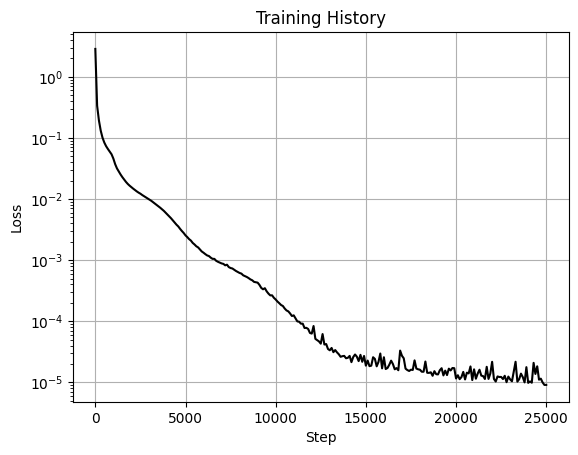

In [10]:
# stable Port-Hamiltonian neural network (sPHNN)
sphnn_derivative = PortHamiltonianNN(
    convex_hamiltonian = True,
    key=model_key
)
sphnn = ODESolver(sphnn_derivative)

sphnn, hist = klax.fit(
    sphnn,
    (ys_flat, ys_t_flat),
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)

hist.plot()

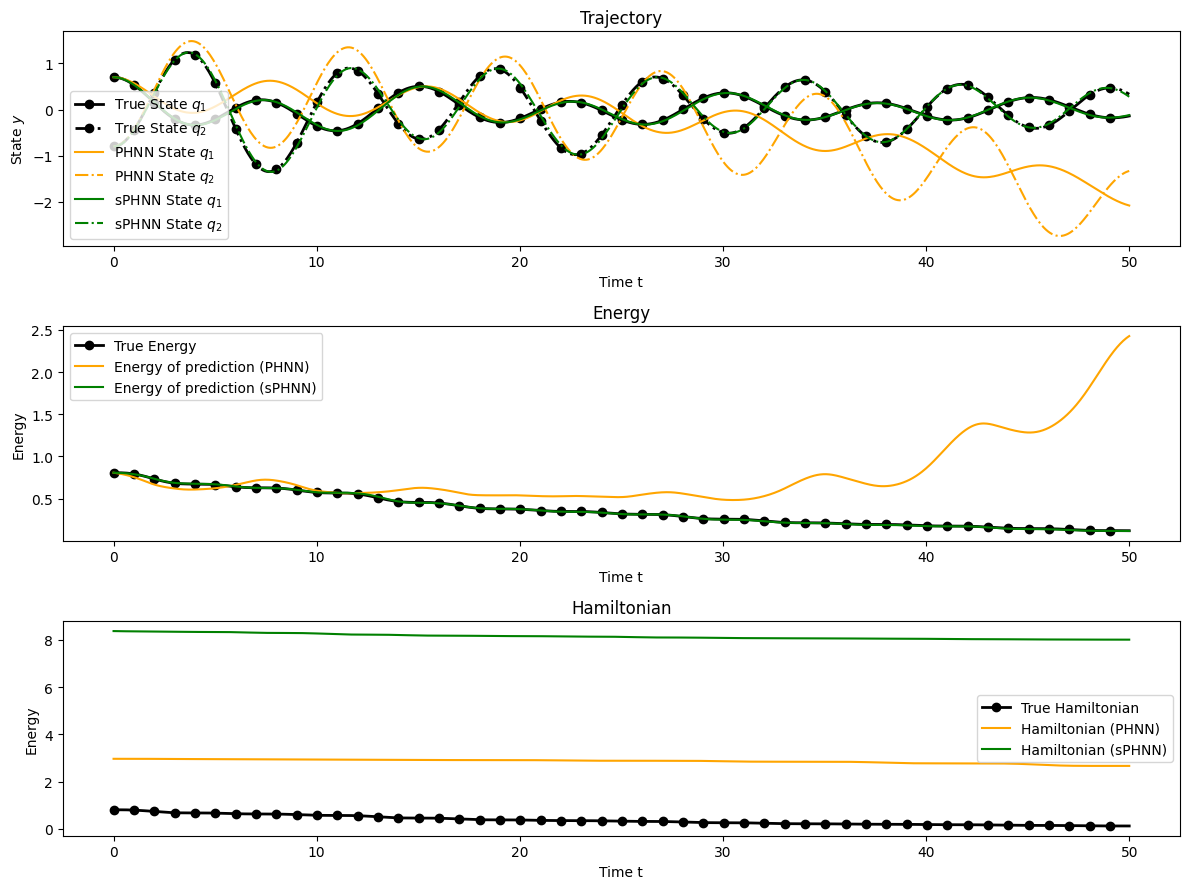

In [11]:
# Plot the model prediction(s)
y0_eval = jnp.array([0.7, -0.8, 0.0, 0.0])  # <<< Initial condition for evaluation
t_max_eval = 50                             # <<< Length of evaluation trajectory
states = "positions"                        # <<< Plot only: "positions", "velocities" or "all"
ts_eval = jnp.linspace(0, t_max_eval, 1000)


fig, axes = plt.subplots(3, 1, figsize=(12, 9))
ys_true = true_system(ts_eval, y0_eval)
plot_trajectory(ts_eval, ys_true, ax=axes[0], label="True State", states=states, **true_kwargs)
E_true = jax.vmap(two_mass_oscillator.get_energy)(ys_true)
plot_energy(ts_eval, E_true, ax=axes[1], label="True Energy", **true_kwargs)   # type: ignore
plot_energy(ts_eval, E_true, ax=axes[2], label="True Hamiltonian", **true_kwargs)   # type: ignore

ys_phnn = klax.finalize(phnn)(ts_eval, y0_eval)
plot_trajectory(ts_eval, ys_phnn, ax=axes[0], states=states, color="orange", label="PHNN State")
E_phnn = jax.vmap(two_mass_oscillator.get_energy)(ys_phnn)
plot_energy(ts_eval, E_phnn, ax=axes[1], color="orange", label="Energy of prediction (PHNN)")   # type: ignore
hamiltonian_phnn = jax.vmap(klax.finalize(phnn.func.hamiltonian))(ys_phnn)
# hamiltonian_phnn += E_true[0]-hamiltonian_phnn[0]   # type: ignore
plot_energy(ts_eval, hamiltonian_phnn, ax=axes[2], color="orange", label="Hamiltonian (PHNN)")   # type: ignore

ys_sphnn = klax.finalize(sphnn)(ts_eval, y0_eval)
plot_trajectory(ts_eval, ys_sphnn, ax=axes[0], states=states, color="green", label="sPHNN State")
E_sphnn = jax.vmap(two_mass_oscillator.get_energy)(ys_sphnn)
plot_energy(ts_eval, E_sphnn, ax=axes[1], color="green", label="Energy of prediction (sPHNN)")   # type: ignore
hamiltonian_sphnn = jax.vmap(klax.finalize(sphnn.func.hamiltonian))(ys_sphnn)
# hamiltonian_sphnn += E_true[0]-hamiltonian_sphnn[0] # type: ignore
plot_energy(ts_eval, hamiltonian_sphnn, ax=axes[2], color="green", label="Hamiltonian (sPHNN)")   # type: ignore

axes[2].set(title="Hamiltonian")
plt.tight_layout()
plt.show()